# Course Two: Data Preparation

Expected time to complete: 45 minutes

## Goal of this course

In this course we will transform our dataset into a format that can be used with a statistical model.

The course is plit into the following parts:
- <a href='#context'>Context</a> 
- <a href='#data_wrangling'>Data wrangling</a> 

<a id='context'></a>
# Context

In the previous tutorial we formulated a data problem, chose a dataset and performed some initial steps that cleaned  and then helped us explore the structure of our data. In this second course we will start looking at how to prepare our dataset to be compatible with the kind of statistical models that can help us solve our problem.


*Data wrangling* is one of the most important steps in the modelling process. It refers to how we prepare a dataset to be ingested into at least one of the many statistical models at our disposal. 

The first step is to make sure we understand the scope of the problem:
- What features of our dataset are we going to use as input to our model (feature selection)?
- Will our model predict something or will it look for unlabeled structure? (supervised vs unsupervised models)
- If predicting, what will the prediction target be? Is it represented as discrete categories or a linear scale (classification or regression)? 

Before we dive back into the code, let's explain a few core concepts that will be helpful to understand before we go any further.

## Supervised vs Unsupervised learning

An important disctinction to make when preparing your data for analysis is whether your problem is suitable for “supervised” or “unsupervised” learning models. 
 
__Unsupervised learning__ models receive input (_explanatory/predictor/independent_ variables or _features_) but no output (or _dependent/target_ variable)  and, essentially, are a way of discovering latent structure in a set of data (clustering is an example of unsupervised learning). Unsupervised models are very useful when working with unlabelled datasets. These models can then be (and often are) combined with supervised models.
 
__Supervised learning__ models, essentially,  learn a mathematical function between an input (_explanatory/predictor/independent_ variables) and an output (the _dependent/target_ variable). These models are used in situations where you know what you want to predict and have explicit input-output pairs for your model to be trained upon.

In our current project we want to forecast the minutes watched on iPlayer (output or target variable) based on past behavior (input or _explanatory/predictor/independent_ variables). We have input-output pairs and are, therefore, in the supervised learning framework.


## Classification vs Regression

Within the supervised learning class of problems there is a further split, based upon the nature of the target variable: discrete or linear. If a dataset is being used to predict one of a finite set of categories, this is called a classification problem and is tackled by a specific set of models called a classifiers. A simple example of a classification problem is a spam email filter where the text of the email must be classified as either legitimate or not. A further example, now of a multi-classification problem is for handwriting recognition, where a hand-written letter is classified as one of a set of 36 (26 letters and 10 digits).

Alternatively, some data problems require the prediction of linear or non-categorical variables. This class of problems is approached using a class of model called regressors. An example of a regression problem would be to predict the number of hits an article receives by analysing the contents of its headline.

In our current project we want to predict _whether or not_ a user watched any content within a two-week period (a classification problem), and we also want to know _how much_ content a user watched within a two-week period (a gregression problem). We will therefore be using both classifiers and regressors in this project.

<a id='data_wrangling'></a>
# Data wrangling

Now we read our data from the last course back in and check that it looks sensible.

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

In [4]:
# Download our output dataset from course 1
data = pd.read_csv('iplayer_data_c1.csv')

# Check that it all looks how we expect it to.
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins,percentage_watched
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,14,Factual,0.350000,0.996190
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama,1.850000,1.000000
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual,0.500000,0.998167
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama,1.366667,1.000000
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,14,Factual,1.616667,1.000000


This should all look very familiar by now. When computing the distribution of our observations among the `twoweek` variable (Course 1 - _Exploratory data analysis_) we saw that we had roughly the same amount of data, except for week 0. Here, as it is not clear why it should have less data (meaning it may be a sign of something not being right), we decide to remove this group from all our subsequent analyses.

In [5]:
data=data[data['twoweek']>0]

In [6]:
data.twoweek.value_counts().sort_index()

1    67222
2    62112
3    60431
4    51941
5    55668
6    49941
7    51286
8    53410
Name: twoweek, dtype: int64

## Model Output

In this section we will walk through the process of how to select and calculate the output of our model. This variable that supervised models predict is know as the _target variable, the output variable_ or the _dependent variable_.

In our project we want to forecast the _next two weeks_ behaviour, so we need to aggregate our target metric for the last two weeks of data available, i.e. how many minutes, if any, of content did each individual audience member consume in the group `twoweek` 8. 

Our target variable will be different for our two different types of model:

- In our __regression model__ our target is the total minutes watched within the final two week period.

- In our __classification model__  our target is a binary or "dummy" variable (0 or 1), where we will forecast whether a user will watch iPlayer or not (total minutes watched > 0) within the final two week period.


#### Regression Model

In our specific problem, we want to forecast what _individual_ users will do. Therefore, we need to pivot our datasets from an __events view__ to a __user view__,  to build both our target and features.

To calculate minutes watched for each audience member we create a pivot table. This process results in a table where each individual audience member is represented as a row and each column describes the total minutes watched for a given two-week period. As all the audience members who consumed no content during a given two-week period are represented as "NA" after this operation, we replace all NAs with zeros. 

In [7]:
# We need to compute the total minutes watched within twoweek 8 for each user
target_reg=pd.pivot_table(data,
                          values='min_watched',
                          index=['user_id'],
                          columns=['twoweek'],
                          aggfunc=sum)[8].reset_index()


# We fill the NAs with 0: corresponds to the users without observations for the last twoweek
# i.e. who didn't watch anything
target_reg=target_reg.fillna(0)
target_reg.head()

,user_id,8
0,0001c6,0.144833
1,000c1a,318.047633
2,001c53,1.980350
3,001d44,10.059067
4,002b2e,0.000000


## Visualise the data

Just for a quick sanity check, we will plot a histogram of the values in the calculated target variable. Remember that this represents a the number of minutes consumed over a two-week period. There are 100 bins and the scale reaches 10000 so each bar represents 100 minutes. This indicates the vast majority of people (represented as the first bar) consumed less than 100 minutes in the final two-week period that we are using for our target variable.

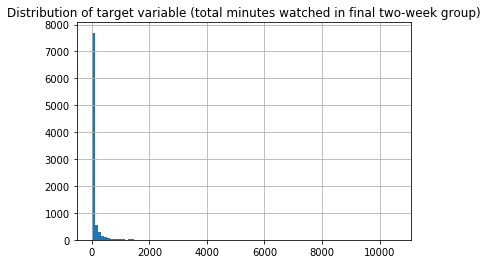

In [51]:
pd.DataFrame(target_reg)[0].hist(bins=100)
plt.title('Distribution of target variable (total minutes watched in final two-week group)')
plt.show()


#### Classification Model

To calcualate our target variable for the classification model we simply replace all numbers from the minutes watched column that are above zero with 1. 

In [8]:
# We build the dummy variable based on the minutes watched on this twoweek
target_class=target_reg.copy()
target_class[8]=np.where(target_class[8]>0,1,0)
target_class.head()

,user_id,8
0,0001c6,1
1,000c1a,1
2,001c53,1
3,001d44,1
4,002b2e,0


## Visualise the data

Now let's visualise the counts of the the classifier target variable. As expected, we see just zeros and ones, while it appears that there are more viewers that did not consume any content in the final two-week period than did.

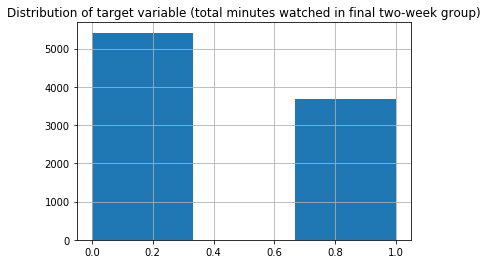

In [54]:
pd.DataFrame(target_class)[0].hist(bins=3)
plt.title('Distribution of target variable (total minutes watched in final two-week group)')
plt.show()

## Model Input

In this section we will walk through the process of how to select and calculate input to our model. The input to a statistical model can often be confusing as it can be described in many different ways. _Independent variables, explanatory variables, predictor variables_ and _features_ are all ways of describing the same thing: the input to your statistical model.

As mentioned in the first course, in most situations the process of selecting our input or _feature engineering_ is an iterative one until you get the feature set that neither “underfits” or “overfits” the data. A feature set that does not contain sufficient information about the output variable will often result in the model underfitting (this can usually be identified by a high _training error_). The solution here is often to add more features. If the feature set contains features that are sensitive to  spurious and random elements of the dataset (and not the underlying population it should be an approximation of), _overfitting_ occurs. Overfitting is characterised by low training error and high _test error_. Overfitting can be tackled by reducing the complexity of your model (often removing features) or using regularisation techniques (https://www.quora.com/What-is-regularization-in-machine-learning). A larger and more diverse training set also helps to reduce overfitting. 

There are various feature selection tools that can be used together with cross-validation to optimise your feature set (e.g. stepwise regression - https://en.wikipedia.org/wiki/Stepwise_regression).  
 
In our project we choose a selection of features that describe how the type viewing habits of a particular user (e.g. “average completion”, “most watched genre”, ”time watched“).


### Regression and Classification Models

The input variables for regression and classifications models are no different so here we will perform the same process for each. Just like for our target variable, our input variables must to have a `user_id` granularity (i.e. each must be paired with a unique audience member).

N.B. As our dataset contains temporal properties, we could have performed a more granular pivot on `user_id x twoweek` (i.e. a user represented as seven rows - one for each two-week group). Splitting the dataset up in this way, allows certain types of model to exploit any temporal contingencies that may exist in the data. To keep things simple, here we stick to a single row per user.

In [9]:
# Create a function that pivots the data based on customer
# and gives us all the features we need
def pivot_data(dataframe):
    #How many minutes did each person watch in each 2 week period
    data=pd.pivot_table(dataframe,values='min_watched', 
                        index=['user_id'],columns=['twoweek'], aggfunc=sum)
    # Fill the weeks they didn't watch in with 0s
    data.fillna(0,inplace=True)
    # How much of average did each viewer watch?
    data['average_completion']=dataframe.groupby('user_id')['percentage_watched'].mean()
    # How many sessions did the person have with us
    data['total_sessions']=dataframe.groupby('user_id')['streaming_id'].nunique()
    # How much did the viewer watch in total this year so far
    data['total_watched']=dataframe.groupby('user_id')['min_watched'].sum()
    # How many times has the viewer watched something
    data['number_watched']=dataframe.groupby('user_id')['streaming_id'].count()
    # Genre most watched by the viewer
    data['most_genre']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                      columns=['enriched_genre'], aggfunc=sum).idxmax(axis=1)
    # Number of genres watched
    data['num_genre']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                     columns=['enriched_genre'], aggfunc=sum).count(axis=1)
    # Favourite day of the week to watch
    data['most_weekday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                        columns=['weekday'], aggfunc=sum).idxmax(axis=1)
    # Number of weekdays watched
    data['num_weekday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                       columns=['weekday'], aggfunc=sum).count(axis=1)
    # Favorite time of day to watch
    data['most_timeday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                        columns=['time_of_day'], aggfunc=sum).idxmax(axis=1)
    # Number of times of day
    data['num_timeday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                       columns=['time_of_day'], aggfunc=sum).count(axis=1)
    return data

In [10]:
# We need to consider here only the "past data", i.e. get rid of the last twoweek observation
# which corresponds to our target
features=pivot_data(data[data['twoweek']<8])
features.reset_index().head()

twoweek,user_id,1,2,3,4,5,6,7,average_completion,total_sessions,total_watched,number_watched,most_genre,num_genre,most_weekday,num_weekday,most_timeday,num_timeday
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,16.831750,3,News,1,weekday_1,2,Evening,2
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,488.301100,38,Factual,5,weekday_3,6,Morning,3
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,3.176167,3,News,2,weekday_2,2,Morning,2
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,14.795717,3,Sport,2,weekday_6,1,Morning,2
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,291.477033,21,Factual,5,weekday_2,5,Evening,3


So now we have a set of features for each user. It currently includes:
- the minutes watched on a two-week basis for the past 14 weeks `1`, `2`,..., `7`

And aggregated on this 14 weeks timeframe:
- the total minutes watched `total_watched`
- the average completion when watching a piece of content `average_completion`
- the number of sessions `total_sessions`
- the number of time a user watched something `number_watched`
- the main genre watched - in terms of minutes and not number of pieces of content - `most_genre`
- the number of different genre watched `num_genre`
- the favourite day of the week to watch - again in minutes watched - `most_weekday`
- the number of differents days of the week a user watched something - `num_weekday`
- the favourite time of the day to watch - again in minutes watched - `most_timeday`
- the number of differents times of the day a user watched something - `num_timeday`

This set of variables constitute our features space to build the models on. Each row in this table (without the userID) is referred to as a _feature vector_.  Note that we could have imagined lots of other features.

### Dummification
Most models only take in quantitative data. We therefore need to convert those that contain strings to categorical numberic representations. This process is often referred to as creating __dummy variables__. To do this we will replace each unique string within a categorical variable with an aditional column which can contain either a zero or a one.  

In [11]:
# Turn our categorical variables into bins so that we can run models on this
features=pd.get_dummies(features).reset_index()
features.head()

,user_id,1,2,3,4,5,6,7,average_completion,total_sessions,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,...,1,0,0,0,0,0,0,1,0,0
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,...,0,0,1,0,0,0,0,0,1,0
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,...,0,1,0,0,0,0,0,0,1,0
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,...,0,0,0,0,0,1,0,0,1,0
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,...,0,1,0,0,0,0,0,1,0,0


### Naming

Here we change the name of the columns representing the two-week _minutes watched_ variables to make them generic:  `tw_lag7_watched`, `tw_lag5_watched`, ..., `tw_lag1_watched`. If we want to use our model later for forecasting purposes on a new dataset with a new timeframe, this will make things much less confusing. 

In [12]:
features = features.rename(columns={1:'tw_lag7_watched',
                                    2:'tw_lag6_watched',
                                    3:'tw_lag5_watched',
                                    4:'tw_lag4_watched',
                                    5:'tw_lag3_watched',
                                    6:'tw_lag2_watched',
                                    7:'tw_lag1_watched'})
features.head()

,user_id,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,...,1,0,0,0,0,0,0,1,0,0
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,...,0,0,1,0,0,0,0,0,1,0
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,...,0,1,0,0,0,0,0,0,1,0
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,...,0,0,0,0,0,1,0,0,1,0
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,...,0,1,0,0,0,0,0,1,0,0


## Visualise the feature distributions

Next we can visualise our feature distributions by plotting histograms for each. There are 36 features in all so no time to look in into the details here, but you should notice that broadly speaking they should reflect the distributions we observed in the previous course. 


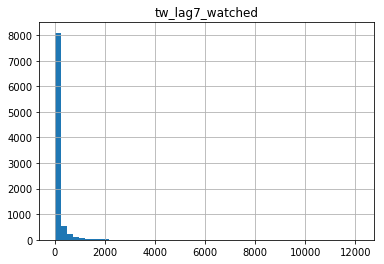

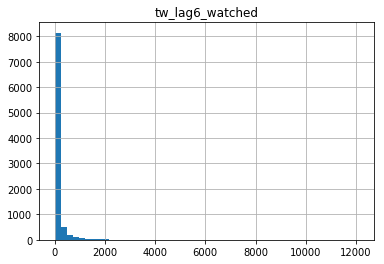

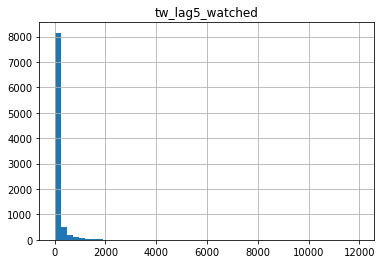

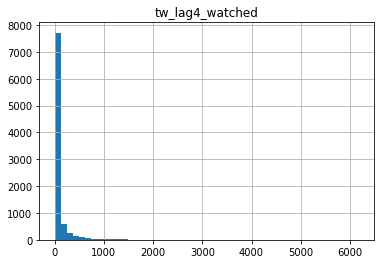

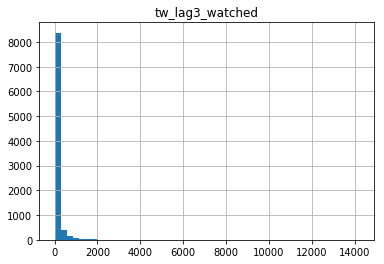

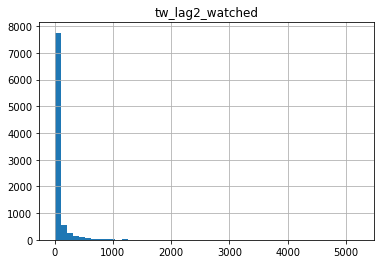

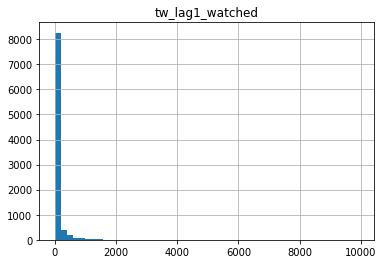

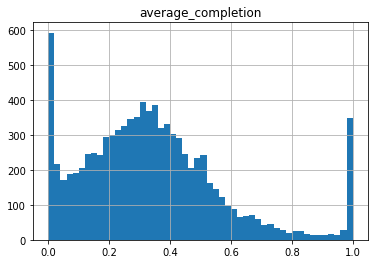

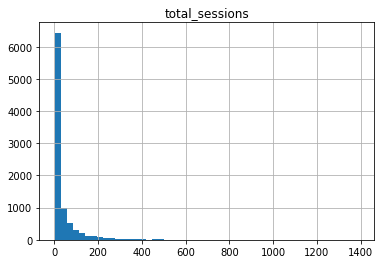

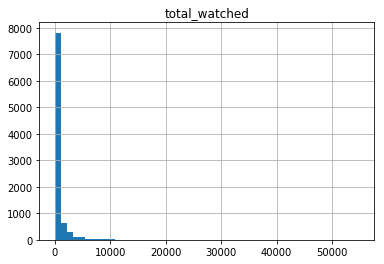

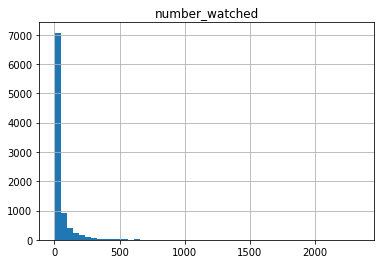

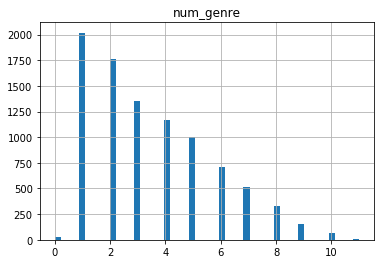

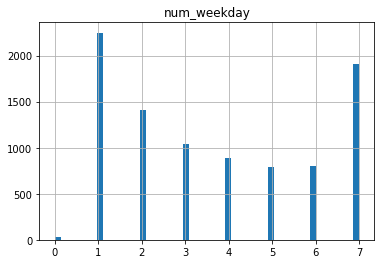

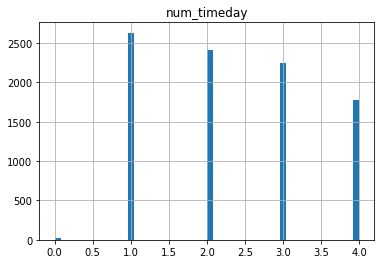

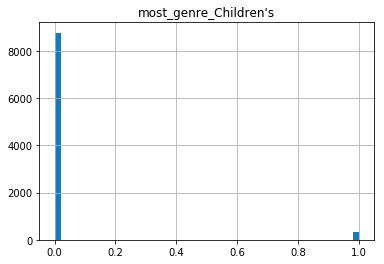

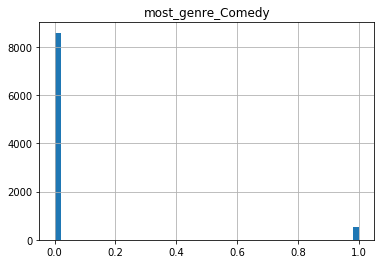

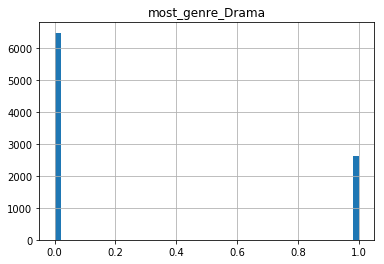

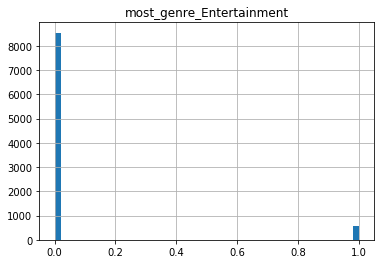

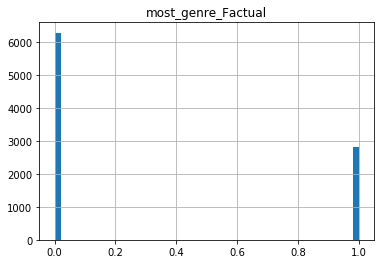

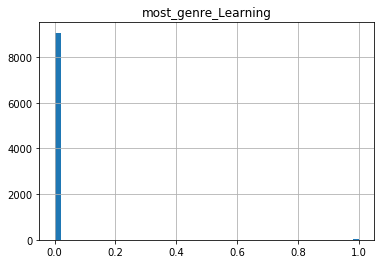

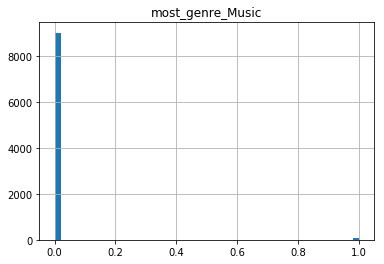

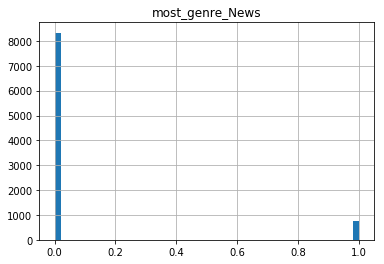

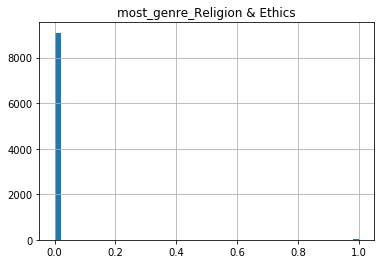

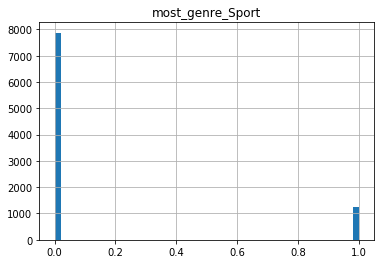

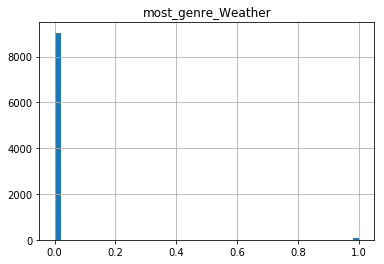

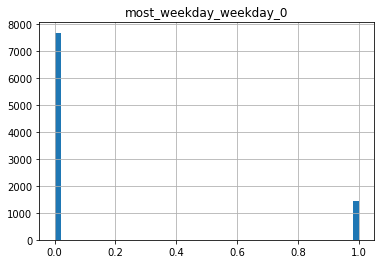

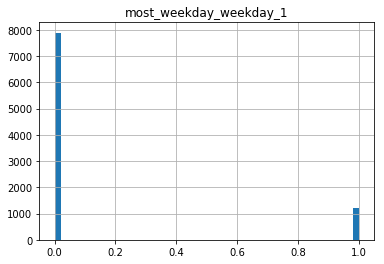

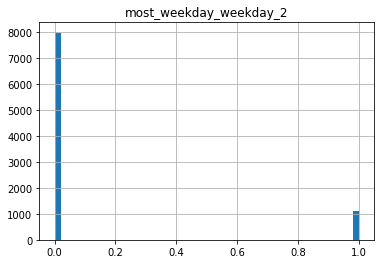

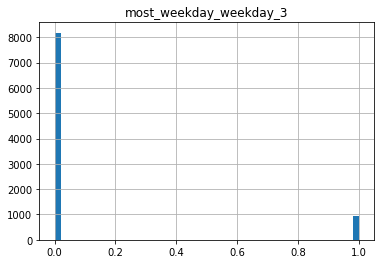

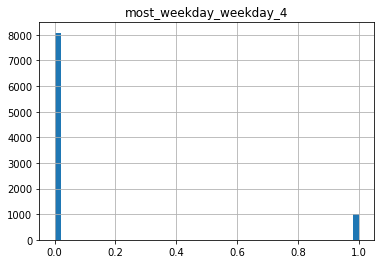

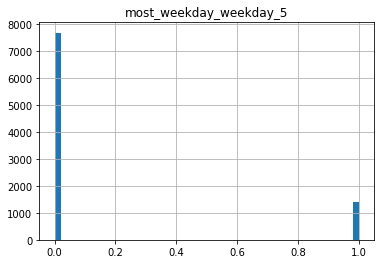

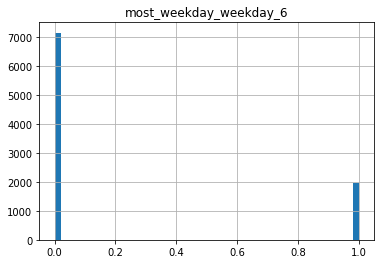

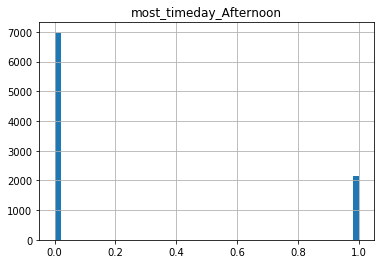

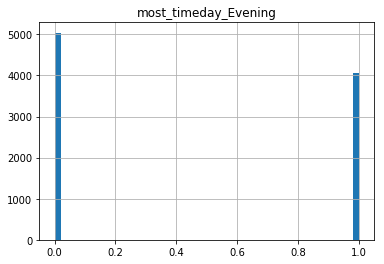

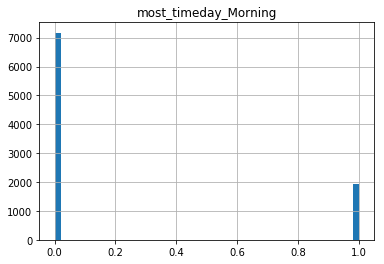

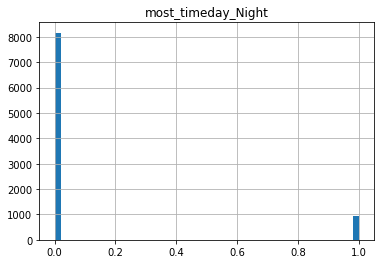

In [62]:
for i in features.columns:
    features[i].hist(bins=50)
    plt.title(i)
    plt.show()
    

# Visualising the relationships between features

A _correlation matrix_ is a good way of getting a quick grasp of the relationships between our features. Correlation is a statistical test which measures the strength of a linear relationship between two variables. The correlation coefficient is a value between -1 and 1. Variables that are perfectly correlated or peerfectly inversely-correlated  have coefficients of 1 and -1 respectively. Variables that have no linear relationship will have a coeffient of zero. A correlation matrix calculates coefficients for every pair of variable and illustrates them n x n grid (where n= the number of features). 

In the correlation matrix of our input features, below,  we can infer that there are strong linear relationships between the first 13 features and weak relationships found between the rest of the features. As the first seven features represent _minutes consumed_ for distinct two-week periods, this is a positive indication that these features will have a strong relationship with the target two-week period we plan to model and predict.

N.B. Correlation matrices are also useful in the feature selection process. They help identify redundancy between your features and therefore identify candidates for removal when needing to reduce complexity.   

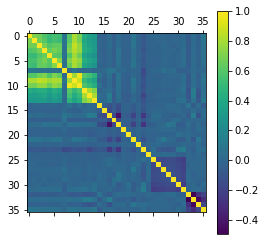

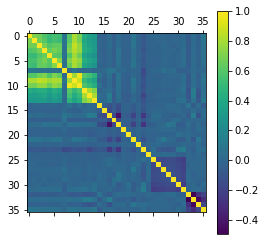

In [59]:
plt.matshow(features.corr())
plt.colorbar()
plt.show()

## Pair Model Input with Model Output

Now we need to ensure that our input variables match up with our output variable. Each row in our input table should match up to the same user ID in our output table. If features or target values are missing for a given user we will get rid of this observation.

In [13]:
# Find the unique users in both the features and the target
users_target=target_reg['user_id'].unique()
users_features=features['user_id'].unique()

# Find those users that are in the target but not in the feature
target_not_feature=[]
for user in users_target:
    if user not in users_features:
        target_not_feature.append(user)

# Find those users that are in the feature but not in the target
feature_not_target=[]
for user in users_features:
    if user not in users_target:
        feature_not_target.append(user)

# Print the size of the two sets
print('In target but not feature:',len(target_not_feature),
      '- In feature but not target:' ,len(feature_not_target))

In target but not feature: 56 - In feature but not target: 0


Remark: it's actually normal to have no one missing in the second case because we built the target variables based on the entire population of the training data. It's more a sanity check here.

Next we need to remove any users that have recorded viewing behaviour before `twoweek` 8. These users can be explained in two ways: either they did not consume any content in the first seven two-week groups or they only signed up to iPlayer in the final two-week group. Neither of these groups are useful from a modeling perspective so we will remove them all. 

N.B  A _time_since_account_created_ variable could be an informative feature to consider in a future model. However, we might need some "business" logic to avoid what is often referred to as "left-censoring" issues. 

In [14]:
# We will set the index to the user_id as this will make it easier to drop rows
# Then we drop the rows and then turn the remaining column into an array
target_reg=target_reg.set_index(['user_id'])
target_reg.drop(target_not_feature,inplace=True)
target_reg.reset_index(inplace=True)
target_reg=target_reg[8].values

# Same for the classification
target_class=target_class.set_index(['user_id'])
target_class.drop(target_not_feature,inplace=True)
target_class.reset_index(inplace=True)
target_class=target_class[8].values
        
# Check to make sure the outcome makes sense
print(target_reg[:10])
print(target_class[:10])

[  1.44833333e-01   3.18047633e+02   1.98035000e+00   1.00590667e+01
   0.00000000e+00   4.79261667e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[1 1 1 1 0 1 0 0 0 0]


In [15]:
# Let's check the size of our datasets
print('Number of samples in the training feature set:',len(features))
print('Number of samples in the training target set (classification):',
      len(target_class))
print('Number of samples in the training target set (regression):',
      len(target_reg))

Number of samples in the training feature set: 9107
Number of samples in the training target set (classification): 9107
Number of samples in the training target set (regression): 9107


### Check for missing data

The last thing we need to do is to replace any possible missing values with zeros and remove the `user_id` field from each row. This field contains useful information for indexing but it does not contain useful modeling information. Therefore, we shall move it from a normal column to an index column.

In [16]:
# We will fill remaining missing values with 0s as we don't know any better
features=features.set_index(['user_id'])
features.fillna(0,inplace=True)
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,total_watched,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,16.831750,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,488.301100,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,3.176167,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,14.795717,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,291.477033,...,0,1,0,0,0,0,0,1,0,0


 Now that we have our data in the perfect condition to ingest into a statistical model, we shall save it on disk so that we can continue working on it in the next course.

In [17]:
features.to_csv('features.csv')
np.savetxt('target.txt',(target_reg,target_class))

# Summary

In this course we looked at the process of preparing our dataset to be ingested into a statistical model.

- We learnt about how data should be prepared in different ways based upon the kind of problem you have (supervised or unsupervised) and the kind of model you intend to use (classification or regression).
- We learnt that for supervised learning problems, input/output pairs need to be calculated from our original dataset. 
- We learnt about useful tools such as the generation of pivot tables that help help translate our dataset from event-centered rows to user-centered rows.